In [1]:
# Experiments with UMAP  21-Oct-2022 J.Beale
# based on https://umap-learn.readthedocs.io/en/latest/basic_usage.html

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline


In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [3]:
group=3
bsize = 15000
stdThresh = 8             # discard rows with standard dev. higher than this
maxlines = group*bsize    # use only this many lines of data

#cars  = pd.read_csv("cars-7390.csv", nrows=maxlines)  # Get training data from CSV file
carsR  = pd.read_csv("data/cars-2021.csv", nrows=maxlines)  # Get training data from CSV file
cars=carsR.drop(carsR.index[:((group-1)*bsize)])       # select out this subset
cars=cars[cars["std"] < stdThresh]                     # remove rows with std.dev. too high
cars["direction"] = np.sign(cars["v2"]) # create new column: direction of motion (-1, +1)
# cars.head()

In [4]:
# cars = cars.dropna()      # get rid of any N/A values
# cars.hour.value_counts()  # display how many events at each hour of day

In [5]:
# sns.pairplot(cars, vars=["v2", "std", "minY", "pixels"], hue='v2');  # slow

In [6]:
import umap                 # this cell takes a while
import umap.plot

In [7]:

cars_data = cars[
    [
        #"day",
        #"hour",
        #"minute",
        "frames",
        "v1",
        "v2",
        "v3",
        "std",
        "minY",
        "pixels",
        "direction"
    ]
].values

# fit_transform(X) calculates the best fit, then transforms the data
# fit(X) just calculates the parameters (per-column) returning the scaler object for later use

Fit = StandardScaler().fit(cars_data)  # get parameters needed to standardize this data
scaled_cars_data = Fit.transform(cars_data)


In [8]:
def ishow(dmap, labels, n):
    hover_data = pd.DataFrame({'index': np.arange(n)+2,
                               'label': labels[:n],
                               'x': dmap.embedding_[:n, 0],
                               'y': dmap.embedding_[:n, 1]
                               })
    p = umap.plot.interactive(dmap, labels=labels,
                              hover_data=hover_data, point_size=8, theme = 'fire')
    umap.plot.show(p)
    

In [9]:
mapper = umap.UMAP(n_neighbors=45,
                   min_dist=0.05,
                   init='spectral',
                   random_state=42).fit(scaled_cars_data) # this is a little slow

In [10]:
carA = cars.to_numpy()  # convert pandas dataframe to numpy array
img_count = carA.shape[0]   # how many total cars in data set

#labels = carA[:,5]          # v1 (average velocity)
v2 = carA[:,6]          # v2 (average velocity)
#labels = carA[:,7]          # v3 (average velocity)
#labels = carA[:,8]          # std (standard deviation of velocity)
#labels = carA[:,9]          # maxY (lowest vertical position in frame)
sz = carA[:,10]          # pixels (size of detected motion area)

ishow(mapper, v2, img_count)  # show an interactive plot of the training data
ishow(mapper, sz, img_count)  # show an interactive plot of the training data

(-5.0, 12.0)

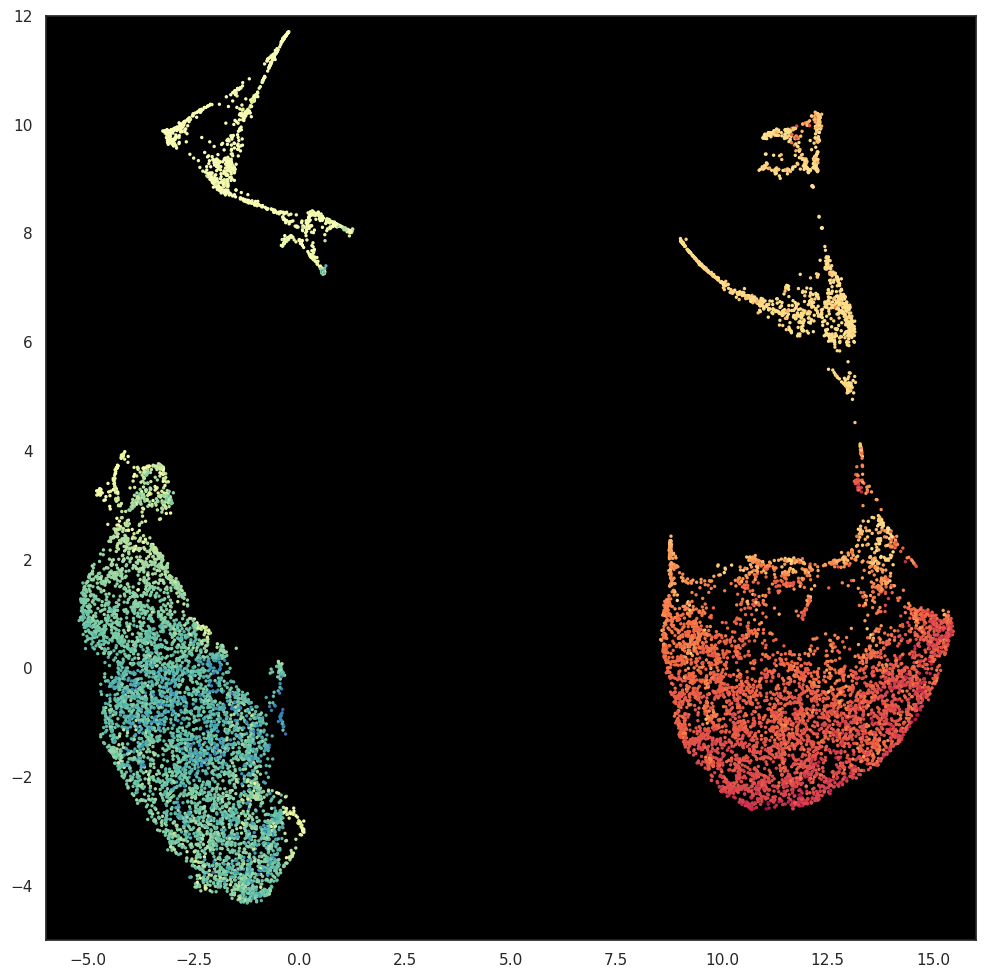

In [293]:
orig_embedding = mapper.transform(scaled_cars_data)   # original training data in map
fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams['axes.facecolor'] = 'black'  # set matplotlib background color
plt.scatter(orig_embedding[:, 0], orig_embedding[:, 1], c=carA[:,6], s=2, cmap='Spectral') # plot training data
plt.xlim([-6, 16])
plt.ylim([-5, 12])


In [ ]:
# === Now, let's load new test data, and see how it fits into the map

In [ ]:
#cars2 = pd.read_csv("data/mailman.csv")  # Get test data from CSV file
#cars2 = pd.read_csv("data/cars-2310.csv")  # Get test data from CSV file
cars2 = pd.read_csv("data/cars-7390.csv")  # Get test data from CSV file

cars2=cars2[cars2["std"] < stdThresh]                     # remove rows with std.dev. too high
cars2["direction"] = np.sign(cars2["v2"]) # create new column: direction of motion (-1, +1)


In [ ]:
cars2_data = cars2[
    [
        #"day",
        #"hour",
        #"minute",
        "frames",
        "v1",
        "v2",
        "v3",
        "std",
        "minY",
        "pixels",
        "direction"
    ]
].values

scaled_cars2_data = Fit.transform(cars2_data)  # transform test data with existing trained Fit parameters

In [11]:
# synthesize a random dataset with same per-column statistics
scaled_cars2_data = np.random.normal(0, 1.0, size=(15000, 7)) # 8 columns of normalized random data
sc2d = scaled_cars2_data  # easier to type

# create new column: direction of motion (-1, +1)
carDir = np.sign(sc2d[:,2]).reshape((sc2d.shape[0],1))
sc2d = np.append(sc2d,carDir,1)  # add the new column onto existing array


In [12]:
test_embedding = mapper.transform(scaled_cars2_data)  # put test data into trained map

(-5.0, 12.0)

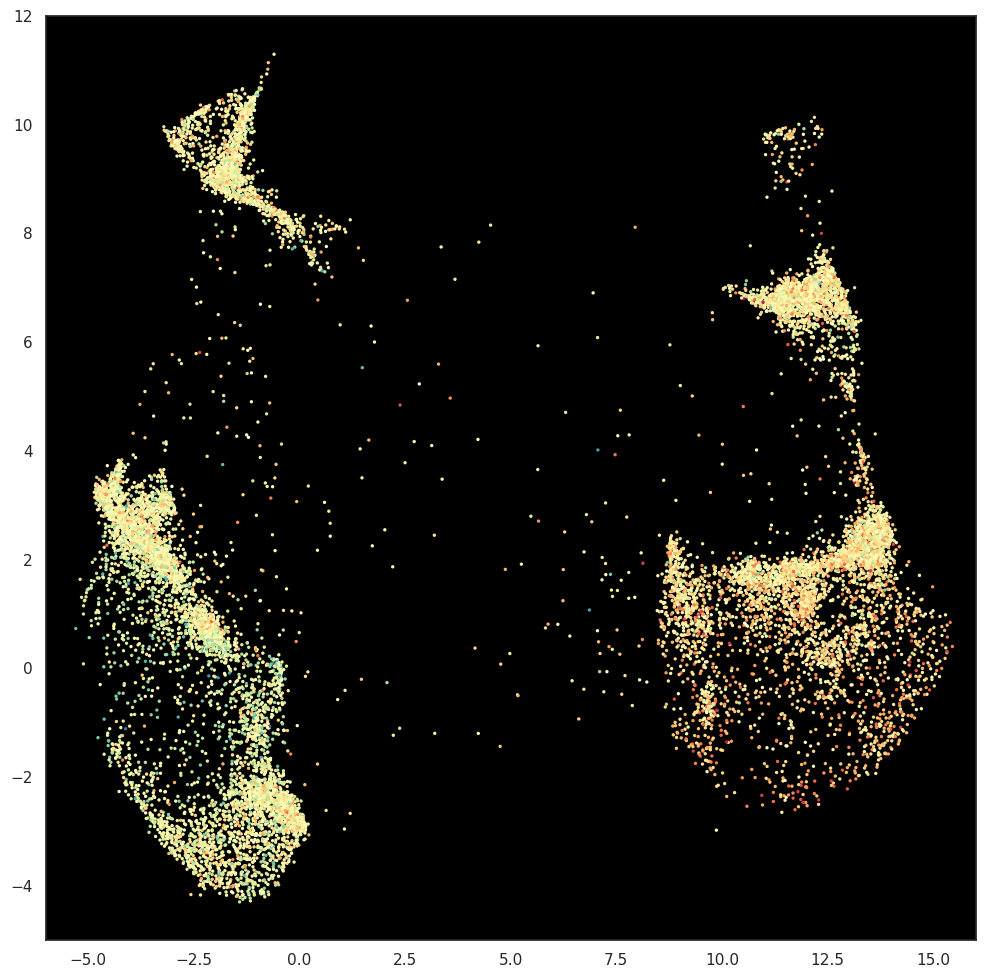

In [13]:
# Display the new data based on the trained UMAP embedding

# index: 1 2 3 4 5  6  7  8   9    10
# value: D H M S v1 v2 v3 std minY size

#car2A = cars2.to_numpy()  # convert pandas dataframe to numpy array
plt.rcParams['axes.facecolor'] = 'black'  # set matplotlib background color

fig, ax = plt.subplots(figsize=(12, 12))
#plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=car2A[:,10], cmap='Spectral')
#plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=car2A[:,9], cmap='Spectral')
#plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=car2A[:,8], cmap='Spectral')
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=sc2d[:,2], s=2, cmap='Spectral')
plt.xlim([-6, 16])
plt.ylim([-5, 12])

In [ ]:
# Find the closest example to a specific point in data mapping
from scipy import spatial

def showNearest(A,pt):
    dist,index = spatial.KDTree(A).query(pt)  # get distance and index of nearest point
    print("Map coords: ", A[index],end="")  # find (x,y) of nearest point
    print(" CSV Line %d" % (index+2)) # corresponding line # in CSV file

pt = [4.94, 0.724]  # choose a point in the output space
showNearest(orig_embedding, pt)  # nearest point in training data
showNearest(test_embedding, pt)  # nearest point in test data
